In [41]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
from torchinfo import summary

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import load_dataset

from transformers import AutoTokenizer,AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline

In [22]:
df = pd.read_csv(r"D:\Datasets\AirlineTweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Finding Null Values

In [23]:
print(len(df))

df.isna().sum()

14640


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [24]:
dataframe = df[['airline_sentiment','text']]
dataframe.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Checking the histogram

<Axes: >

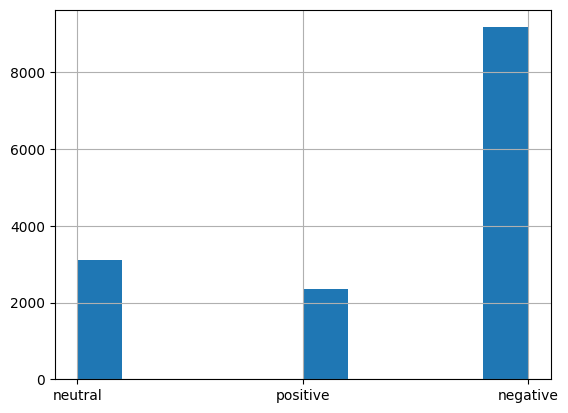

In [25]:
dataframe['airline_sentiment'].hist()

Developing target map

In [26]:
target_map = {'positive': 1, 'negative' : 0, 'neutral' : 2}

dataframe['target'] = dataframe['airline_sentiment'].map(target_map)

dataframe.head()

C:\Users\Omen\AppData\Local\Temp\ipykernel_14392\1726844766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['target'] = dataframe['airline_sentiment'].map(target_map)


,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [27]:
dataframe.drop('airline_sentiment',axis=1,inplace=True)

C:\Users\Omen\AppData\Local\Temp\ipykernel_14392\3410537462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop('airline_sentiment',axis=1,inplace=True)


In [28]:
dataframe.rename(columns={'target': 'labels'}, inplace=True)

C:\Users\Omen\AppData\Local\Temp\ipykernel_14392\3226833047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.rename(columns={'target': 'labels'}, inplace=True)


In [29]:
dataframe.to_csv("sentiments.csv",index=False)

In [30]:
dataset = load_dataset('csv',data_files='sentiments.csv')

Generating train split: 14640 examples [00:00, 236148.87 examples/s]


In [31]:
split = dataset['train'].train_test_split(test_size=0.3, seed=42)

In [32]:
split

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4392
    })
})

Tokenization

In [33]:
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [34]:
def tokenizer_fn(batch):
    return tokenizer(batch['text'],truncation=True)

tokenized_dataset = split.map(tokenizer_fn, batched = True)

Map: 100%|██████████| 4392/4392 [00:00<00:00, 21453.02 examples/s]


Automodel is a term used to describe a machine learning model that can be automatically generated or trained

Trainer is a class that provides a high-level API for training a machine learning model. It can be used to train a model using any torch.nn.Module instance, including models implemented using the transformers library.

TrainingArguments is a class that defines the arguments used to configure a training run. It includes arguments such as the number of training steps, the learning rate, the batch size, and many others. When using the Trainer class, an instance of TrainingArguments is passed to the constructor to specify the configuration for a training run.

In [35]:
# Defining a pretrained Architecture

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           2,307
Total params: 10

In [37]:
# defining tranining arguments

training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64
                                  )

In [38]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [39]:
trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [40]:
trainer.train()

                                        
  0%|          | 0/1923 [07:48<?, ?it/s]          

{'loss': 0.5272, 'grad_norm': 4.763123989105225, 'learning_rate': 3.699947997919917e-05, 'epoch': 0.78}





































































                                        
                                               

  0%|          | 0/1923 [08:18<?, ?it/s]       



{'eval_loss': 0.4534812271595001, 'eval_accuracy': 0.8326502732240437, 'eval_f1_score': 0.8326502732240437, 'eval_runtime': 10.2152, 'eval_samples_per_second': 429.948, 'eval_steps_per_second': 6.755, 'epoch': 1.0}


                                        
  0%|          | 0/1923 [09:15<?, ?it/s]           

{'loss': 0.3203, 'grad_norm': 4.501567363739014, 'learning_rate': 2.399895995839834e-05, 'epoch': 1.56}





































































                                        
                                                

  0%|          | 0/1923 [10:06<?, ?it/s]       



{'eval_loss': 0.47311463952064514, 'eval_accuracy': 0.8401639344262295, 'eval_f1_score': 0.8401639344262295, 'eval_runtime': 10.4372, 'eval_samples_per_second': 420.804, 'eval_steps_per_second': 6.611, 'epoch': 2.0}


                                        
  0%|          | 0/1923 [10:39<?, ?it/s]           

{'loss': 0.2159, 'grad_norm': 3.3208653926849365, 'learning_rate': 1.0998439937597505e-05, 'epoch': 2.34}





































































                                        
                                                

  0%|          | 0/1923 [11:51<?, ?it/s]       



{'eval_loss': 0.6613582968711853, 'eval_accuracy': 0.8431238615664846, 'eval_f1_score': 0.8431238615664846, 'eval_runtime': 10.2342, 'eval_samples_per_second': 429.149, 'eval_steps_per_second': 6.742, 'epoch': 3.0}


                                        
100%|██████████| 1923/1923 [05:17<00:00,  6.07it/s]

{'train_runtime': 317.0153, 'train_samples_per_second': 96.98, 'train_steps_per_second': 6.066, 'train_loss': 0.30252827819411604, 'epoch': 3.0}


TrainOutput(global_step=1923, training_loss=0.30252827819411604, metrics={'train_runtime': 317.0153, 'train_samples_per_second': 96.98, 'train_steps_per_second': 6.066, 'train_loss': 0.30252827819411604, 'epoch': 3.0})

In [43]:
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-1282')

predictions = saved_model(split['test']['text'])

print(predictions[:10])

[{'label': 'LABEL_1', 'score': 0.9192118644714355}, {'label': 'LABEL_1', 'score': 0.9199649095535278}, {'label': 'LABEL_0', 'score': 0.589942991733551}, {'label': 'LABEL_1', 'score': 0.6846145391464233}, {'label': 'LABEL_0', 'score': 0.8350870609283447}, {'label': 'LABEL_0', 'score': 0.9981676340103149}, {'label': 'LABEL_2', 'score': 0.938347578048706}, {'label': 'LABEL_2', 'score': 0.890294075012207}, {'label': 'LABEL_1', 'score': 0.8874194025993347}, {'label': 'LABEL_0', 'score': 0.9982792139053345}]


In [51]:
def get_label(d):
  return d

predictions = [get_label(d) for d in predictions]

print("acc:",accuracy_score(split['test']['labels'], predictions))

print("f1:",f1_score(split['test']['labels'], predictions, average = 'macro'))

acc: 0.8401639344262295
f1: 0.786285328009957


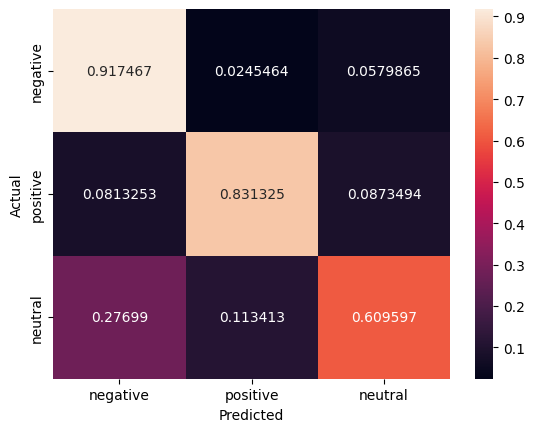

In [47]:
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['labels'],predictions, normalize = 'true')
plot_cm(cm)